In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

In [14]:
#!pip install mysql-connector-python


In [2]:
# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='shalu1011',
    database='ecommerce'
)
cur = conn.cursor()

###  1. List all unique cities where customers are located.

In [3]:
query="""select distinct(customer_city) from customers"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


In [8]:
df.isnull().sum

<bound method DataFrame.sum of           0
0     False
1     False
2     False
3     False
4     False
...     ...
4114  False
4115  False
4116  False
4117  False
4118  False

[4119 rows x 1 columns]>

### 2. Count the number of orders placed in 2017.

In [18]:
query="""select count(order_id) from orders where year(order_purchase_timestamp)=2017 """
cur.execute(query)
data=cur.fetchall()
"Total orders placed in the year 2017:",data[0][0]

('Total orders placed in the year 2017:', 45101)

### 3. Find the total sales per category.

In [19]:
query=""" select products.`product category` as category,round(sum(payments.payment_value),2) sales
from products join order_items 
on products.product_id=order_items.product_id
join payments 
on payments.order_id=order_items.order_id
group by category"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Category','Sales'])
df.head()

,Category,Sales
0,perfumery,261722.49
1,Furniture Decoration,779135.85
2,telephony,253232.80
3,bed table bath,884833.32
4,automotive,406223.02


### 4. Calculate the percentage of orders that were paid in installments.

In [20]:
query="""select (sum(payment_installments>1)/count(*))*100 from payments"""
cur.execute(query)
data=cur.fetchall()
data

[(Decimal('49.4176'),)]

### 5. Count the number of customers from each state. 

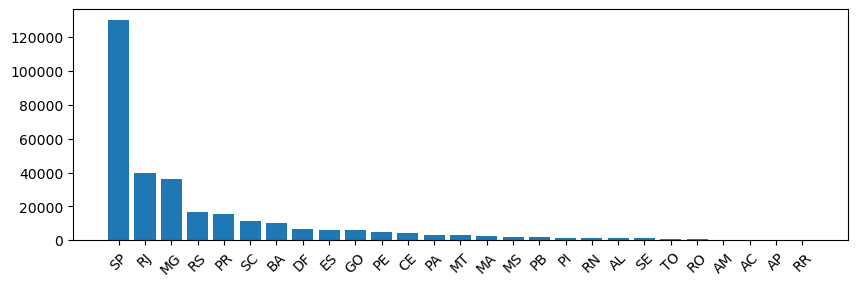

In [22]:
query = """SELECT customer_state, COUNT(customer_id) FROM customers GROUP BY customer_state"""
cur.execute(query)
data = cur.fetchall(
df = pd.DataFrame(data, columns=['State', 'Customer_count'])
df = df.sort_values('Customer_count', ascending=False)
plt.figure(figsize=(10, 3))
plt.bar(df['State'], df['Customer_count'])
plt.xticks(rotation=45)
plt.show()


### 6. Calculate the number of orders per month in 2018.

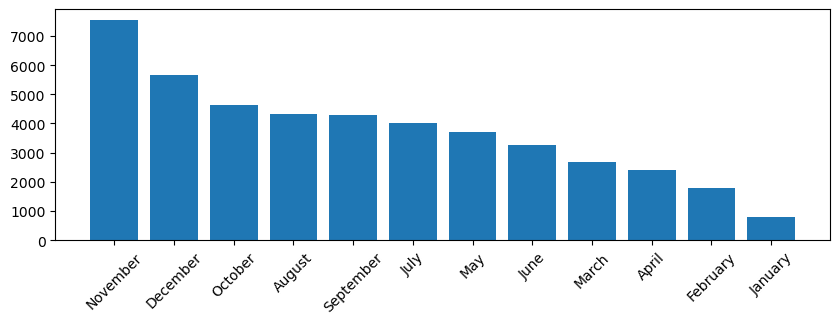

In [24]:
query="""select monthname(order_purchase_timestamp) months ,count(order_id) order_count 
from orders
 where year(order_purchase_timestamp)=2017 group by months """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Months','Order_count'])
df=df.sort_values('Order_count',ascending=False)
plt.figure(figsize=(10,3))
plt.bar(df['Months'],df['Order_count'])
plt.xticks(rotation=45)
plt.show()

### 7. Find the average number of products per order, grouped by customer city.

In [25]:
query="""with count_per_order as (select orders.order_id,orders.customer_id,count(order_items.order_id)
as oc
from orders join order_items
on
orders.order_id=order_items.order_id
group by orders.order_id,orders.customer_id)
 
select customers.customer_city,round(avg(count_per_order.oc),2) as average_orders
from customers join count_per_order
on customers.customer_id=count_per_order.customer_id
group by customers.customer_city 
order by average_orders desc"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['customer_city','Avg_orders'])
df.head()

,customer_city,Avg_orders
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,inconfidentes,6.00
4,matias olimpio,5.00


### 8. Calculate the percentage of total revenue contributed by each product category.

In [41]:
query = """
SELECT 
    upper(products.`product category`) AS category,
    ROUND(SUM(payments.payment_value) / 
          (SELECT SUM(payment_value) FROM payments) * 100, 2) AS sales_per
FROM products 
JOIN order_items ON products.product_id = order_items.product_id
JOIN payments ON payments.order_id = order_items.order_id
GROUP BY category order by sales_per desc"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['Category', 'Sales'])
df


,Category,Sales
0,BED TABLE BATH,5.53
1,HEALTH BEAUTY,5.26
2,COMPUTER ACCESSORIES,5.24
3,FURNITURE DECORATION,4.87
4,WATCHES PRESENT,4.75
...,...,...
68,CDS MUSIC DVDS,0.01
69,PC GAMER,0.01
70,FLOWERS,0.00
71,FASHION CHILDREN'S CLOTHING,0.00


### 9.Identify the correlation between product price and the number of times a product has been purchased.

In [28]:
query="""SELECT 
  product_id,
  COUNT(*) AS times_purchased,
  round(avg(price),2)AS avg_price
FROM order_items 
GROUP BY product_id"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['product_id','times_purchased','avg_price'])
correlation = df[['avg_price', 'times_purchased']].corr()
print("\nCorrelation between average price and times purchased:")
print(correlation)                  


Correlation between average price and times purchased:
                 avg_price  times_purchased
avg_price         1.000000        -0.034105
times_purchased  -0.034105         1.000000


### 10.Calculate the total revenue generated by each seller, and rank them by revenue.

In [45]:
query = """ select *,dense_rank() over (order by revenue desc) as rn from 
(select order_items.seller_id,round(sum(payments.payment_value),2) revenue
from order_items join payments
on order_items.order_id=payments.order_id
group by order_items.seller_id) a  """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df

,seller_id,revenue,rank
0,7c67e1448b00f6e969d365cea6b010ab,267922.08,1
1,1f50f920176fa81dab994f9023523100,174337.69,2
2,1025f0e2d44d7041d6cf58b6550e0bfa,166191.19,3
3,4a3ca9315b744ce9f8e9374361493884,155438.07,4
4,53243585a1d6dc2643021fd1853d8905,155058.87,5
...,...,...,...
2676,cc1f04647be106ba74e62b21f358af25,20.19,2660
2677,c1dde11f12d05c478f5de2d7319ad3b2,19.89,2661
2678,702835e4b785b67a084280efca355756,18.56,2662
2679,c6381b1321d7d97717a5bb4ed5b77882,18.29,2663


### 11.Calculate the moving average of order values for each customer over their order history.

In [37]:
query="""select customer_id,order_purchase_timestamp,payments,avg(payments)
over(partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row) as mov_avg
from 
(select customer_id,order_purchase_timestamp,payments.payment_value as payments
from payments join orders on
payments.order_id=orders.order_id) as a;"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['customer_id','order_purchase_timestamp','payments','Mov_avg'])
df.head()

,customer_id,order_purchase_timestamp,payments,Mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.41
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.42
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.35
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.01


### 12.Calculate the cumulative sales per month for each year.

In [43]:
query=""" select years,months,payment,sum(payment) over(order by years,months) cummulative_sales from
(Select year(order_purchase_timestamp)  years,
  month(order_purchase_timestamp) months,
  round(SUM(payments.payment_value),2) as payment 
from orders
join payments on orders.order_id = payments.order_id
group by years, months
order by years, months) as a;"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Years','Months','Payment','cummulative_sales'])
df

,Years,Months,Payment,cummulative_sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


### 13.Calculate the year-over-year growth rate of total sales.

In [47]:
query=""" WITH a AS (SELECT YEAR(order_purchase_timestamp) AS years,
    SUM(payments.payment_value) AS payment
  FROM orders 
  JOIN payments ON orders.order_id = payments.order_id
  GROUP BY years)
SELECT years,
(((payment-lag(payment,1) over (order by years))/lag(payment,1) over (order by years))*100) growth_by_year 
from a;"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Years','Growth_over_year'])
df

,Years,Growth_over_year
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


### 14.Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

query="""with a as (select customers.customer_id,min(orders.order_purchase_timestamp) from customers join orders
on customers.customer_id=orders.customer_id
group by customers.customer_id),
 b as (select a.customer_id ,count(distinct orders.order_purchase_timestamp) from a join orders 
 on orders.customer_id = a.customer_id and orders.order_purchase_timestamp>first_order
 group by a.customer_id)
 (select 100*(count(distinct a.customer_id)/count(distinct b.customer_id)) from a left join b on a.customer_id=b.customer_id;"""
cur.execute(query)
data=cur.fetchall()
data

In [52]:
query = """
WITH first_orders AS (
    SELECT 
        customer_id,
        MIN(order_purchase_timestamp) AS first_order
    FROM orders
    GROUP BY customer_id
),
repeat_orders AS (
    SELECT 
        o.customer_id
    FROM orders o
    JOIN first_orders f ON o.customer_id = f.customer_id
    WHERE o.order_purchase_timestamp > f.first_order
      AND o.order_purchase_timestamp <= DATE_ADD(f.first_order, INTERVAL 6 MONTH)
    GROUP BY o.customer_id
)
SELECT 
    ROUND(COUNT(DISTINCT repeat_orders.customer_id) * 100.0 / COUNT(DISTINCT first_orders.customer_id), 2) AS retention_rate
FROM first_orders
LEFT JOIN repeat_orders ON first_orders.customer_id = repeat_orders.customer_id;
"""

cur.execute(query)
data = cur.fetchall()
data


[(Decimal('0.00'),)]

### 15.Identify the top 3 customers who spent the most money in each year.

In [57]:
query = """WITH a AS (SELECT orders.customer_id,
    YEAR(orders.order_purchase_timestamp) AS years,
    SUM(payments.payment_value) AS total_spent
  FROM orders 
  JOIN payments ON orders.order_id = payments.order_id
GROUP BY orders.customer_id, YEAR(orders.order_purchase_timestamp)),
ranked_customers AS (SELECT *, 
RANK() OVER (PARTITION BY years ORDER BY total_spent DESC) AS customer_rank
  FROM a)
SELECT * FROM ranked_customers
WHERE customer_rank <= 3;"""

cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data,columns=['customer_id','years','total_spent','Rank'])
df.head(3)

,customer_id,years,total_spent,Rank
0,a9dc96b027d1252bbac0a9b72d837fc6,2016,1423.55,1
1,1d34ed25963d5aae4cf3d7f3a4cda173,2016,1400.74,2
2,4a06381959b6670756de02e07b83815f,2016,1227.78,3
